## 9. 分散表現(カウントベース)

### 単語の意味
単語の意味をコンピュータに理解させる手法として、
- シソーラスによる手法
- カウントベースによる手法
- 推論ベースによる手法(word2vec)

の3つを考える。

#### シソーラス
**シソーラス**とは類語辞書であり、同じ意味の単語(同義語)や意味の似た単語(類義語)が同じグループに分類されている。  
最も有名なシソーラスは**WordNet**である。  
シソーラスには、
- 時代の変化に対応するのが困難
- 人の作業コストが高い
- 単語の細かなニュアンスを表現できない

などの問題点がある。

#### カウントベースの手法
自然言語処理の研究やアプリケーションのために目的をもって収集されたテキストデータを**コーパス**と呼ぶ。  
有名なコーパスとしては、WikipediaやGoogle Newsなどのテキストや、夏目漱石などの作家の作品群もコーパスとして利用される。  
カウントベースの手法ではコーパスを利用する。

In [11]:
import numpy as np

def preprocess(text):
    # 前処理
    text = text.lower() # すべての文字を小文字に変換
    text = text.replace('.', ' .') # 「.」も1単語として扱うためスペースを入れる。
    words = text.split(' ')
    
    # 単語辞書、ID辞書の作成
    word_to_id = {} # 単語: ID
    id_to_word = {} # ID: 単語

    for word in words: # 単語のリスト
        if word not in word_to_id: # word_to_idに存在しない場合
            new_id = len(word_to_id) # 新しいIDの発行
            word_to_id[word] = new_id
            id_to_word[new_id] = word
    
    # コーパスの作成(単語リストをIDリストに変換)
    corpus = [word_to_id[w] for w in words]
    
    return corpus, word_to_id, id_to_word

text = 'You say goodbye and I say Hello.'

corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)
print(word_to_id)
print(id_to_word)

[0, 1, 2, 3, 4, 1, 5, 6]
{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


#### 分散表現
世の中にはさまざまな「色」が存在し、「コバルトブルー」や「シンクレッド」など固有の名前が付けられている。  
一方で、色はRGBの3成分の値(3次元ベクトル)で表すことができる。  
RGBのベクトル表現のほうが、正確に色を指定できるだけでなく、色同士の関連性(似た色かどうか)も容易に判断できる。  
「色」のベクトル表現のようなことを「単語」で行うことを、単語の**分散表現**と呼ぶ。

#### 分布仮説
「単語の意味は、周囲の単語によって形成される」という考え方を**分布仮説**と呼び、多くの研究がこの仮説に基づいている。  
注目する単語に対して、その周囲に存在する単語を**コンテキスト**と呼ぶ。
```
you say goodbye and i say hello.
```
例えば、上の文で「goodbye」という単語に注目したとき、**ウィンドウサイズ**が2の場合「you, say, and, i」がコンテキストに相当する。

#### 共起行列
分布仮説に基づき単語をベクトルで表現するには、周囲の単語をカウントする方法が考えられる。  
次の文についてウィンドウサイズが1の場合を考える。
```
you say goodbye and i say hello.
```

各単語について、そのコンテキストに含まれる単語の頻度をカウントしテーブルにまとめると(「say」は2個含まれている)、  

||you|say|goodbye|and|i|hello|.|
|-|-|-|-|-|-|-|-|
|you|0|1|0|0|0|0|0|
|say|1|0|1|0|1|1|0|
|goodbye|0|1|0|1|0|0|0|
|and|0|0|1|0|1|0|0|
|i|0|1|0|1|0|0|0|
|hello|0|1|0|0|0|0|1|
|.|0|0|0|0|0|1|0|

このようなテーブルは**共起行列**と呼ばれる。

In [18]:
def create_co_matrix(corpus, vocab_size, window_size=1):
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)
    
    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size + 1):
            # コンテキストのインデックスを計算
            left_idx = idx - 1
            right_idx = idx + 1
            
            # 左と右がはみだしていないかチェック
            if left_idx >= 0: # 左はマイナスにならない
                left_word_id = corpus[left_idx] # IDを抽出
                co_matrix[word_id, left_word_id] += 1 # co_matrixに加算
            
            if right_idx < corpus_size: # コーパス(文章)より長くならない
                right_word_id = corpus[right_idx] # IDを抽出
                co_matrix[word_id, right_word_id] += 1 # co_matrixに加算
    
    return co_matrix

create_co_matrix(corpus=corpus, vocab_size=len(word_to_id), window_size=1)

array([[0, 1, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 1, 0],
       [0, 1, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 0],
       [0, 1, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0]])

#### 類似度
単語のベクトル表現の類似度として**コサイン類似度**がよく用いられる。  
どれだけ同じ方向を向いているかを表す。
$$
similarity(\boldsymbol{x}, \boldsymbol{y})=\frac{\boldsymbol{x}・\boldsymbol{y}}{|\boldsymbol{x}||\boldsymbol{y}|}=\frac{x_1y_1+\cdots+x_ny_n}{\sqrt{x_1^2+\cdots+x_n^2}\sqrt{y_1^2+\cdots+y_n^2}}
$$

In [22]:
def cos_similarity(x, y, eps=1e-8):
    nx = x / (np.sqrt(np.sum(x**2)) + eps)
    ny = y / (np.sqrt(np.sum(y**2)) + eps)
    return np.dot(nx, ny)

vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
c0 = C[word_to_id['you']]
c1 = C[word_to_id['i']]
print(cos_similarity(c0, c1))

0.7071067691154799


In [24]:
def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    # クエリを取り出す
    if query not in word_to_id:
        print('%s is not found' % query)
        return
    
    print('\n[query]' + query)
    query_id = word_to_id[query] # クエリのID
    query_vec = word_matrix[query_id] # クエリの単語ベクトル
    
    # コサイン類似度の計算
    vocab_size = len(id_to_word)
    similarity = np.zeros(vocab_size)
    
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)
    
    # コサイン類似度の高い順に出力
    count = 0
    for i in (-1*similarity).argsort():
        # 同じベクトルであればスキップ
        if id_to_word[i] == query:
            continue
        print(' %s %s' % (id_to_word[i], similarity[i]))
        
        count += 1
        if count >= top:
            return

most_similar('you', word_to_id, id_to_word, C, top=5)


[query]you
 goodbye 0.7071067691154799
 i 0.7071067691154799
 hello 0.7071067691154799
 say 0.0
 and 0.0


#### 相互情報量
共起行列では、例えば「the」などの高頻度で出現する単語があった場合に強い関連性を持ってしまうという問題点がある。  
そこで、次の式で定義される**相互情報量(PMI)**を利用する。この値が高いほど関連性が高い。  
$$
PMI(x,y)=\log_2\frac{P(x,y)}{P(x)P(y)}
$$

ここで、$P(x)$は$x$が起こる確率、$P(y)$は$y$が起こる確率、$P(x,y)$は$x$と$y$が同時に起こる確率を表す。  
例えば、10000個の単語からなるコーパスで「the」という単語が100回出現したとすれば、$P('the')=100/10000=0.01$と計算できる。  
共起行列$C$として、単語xとyの共起する回数を$C(x,y)$、xとyの出現する回数を$C(x)$、$C(y)$で表す。  
コーパスに含まれる単語数を$N$とすると、
$$
PMI(x,y)=\log_2\frac{P(x,y)}{P(x)P(y)}=\log_2\frac{\frac{C(x,y)}{N}}{\frac{C(x)}{N}\frac{C(y)}{N}}=\log_2\frac{C(x,y)・N}{C(x)C(y)}
$$
のように書き換えられる。  
共起する回数が0の場合、$-\infty$となってしまうので**正の相互情報量(PPMI)**が使用される。
$$
PPMI(x,y)=\max(0,PMI(x,y))
$$

In [25]:
def ppmi(C, verbose=False, eps=1e-8):
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0
    
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i,j] * N / (S[j]*S[i]) + eps)
            M[i, j] = max(0, pmi)
            
            if verbose:
                cnt += 1
                
                if cnt % (total//100 + 1) == 0:
                    print('%.1f%% done' % (100*cnt/total))
    return M

In [27]:
W = ppmi(C)

np.set_printoptions(precision=3)
print('covariance matrix')
print(C)
print('-'*50)
print('PMI')
print(W)

covariance matrix
[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
--------------------------------------------------
PMI
[[0.    1.807 0.    0.    0.    0.    0.   ]
 [1.807 0.    0.807 0.    0.807 0.807 0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.    1.807 0.    1.807 0.    0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.807 0.    0.    0.    0.    2.807]
 [0.    0.    0.    0.    0.    2.807 0.   ]]


#### 次元削減
次元削減として、以下の式で表される**特異値分解(SVD)**を使用する。
$$
\boldsymbol{X}=\boldsymbol{U}\boldsymbol{S}\boldsymbol{V^T}
$$

$\boldsymbol{S}$は、対角行列であり、$\boldsymbol{U}$は直交行列となる。  
この直交行列は何らかの空間の軸(基底)を表している。この空間を「単語空間」として扱う。  
対角行列$\boldsymbol{S}$の対角成分は**特異値**が大きい順に並んでいて、対応する軸の重要度とみなすことができる。

[0 1 0 0 0 0 0]
[0.    1.807 0.    0.    0.    0.    0.   ]
[ 0.000e+00  3.409e-01 -1.205e-01 -3.886e-16 -1.110e-16 -9.323e-01
 -2.426e-17]


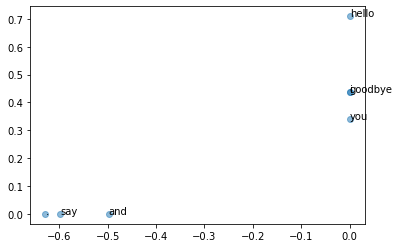

In [30]:
import matplotlib.pyplot as plt

U, S, V = np.linalg.svd(W)

print(C[0])
print(W[0])
print(U[0])

for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))

plt.scatter(U[:,0], U[:,1], alpha=0.5)
plt.show()